## Machine Learning : Theory and Applications (2025/26)
Simona Cocco & Vito Dichio

[✉ simona.cocco@phys.ens.fr](mailto:simona.cocco@phys.ens.fr) \\
[✉ vito.dichio@phys.ens.fr](mailto:vito.dichio@phys.ens.fr)


#### Bibliography:
[1] Rosenblatt, F. (1958). *The Perceptron: A probabilistic model for information storage and organization in the brain*. *Psychological Review*, 65(6), 386–408.

[2] LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). *Gradient-based learning applied to document recognition*. *Proceedings of the IEEE*, 86(11), 2278–2324.

[3] Bishop, C. M., & Bishop, H. (2023). Deep learning: Foundations and concepts. Springer Nature.

[4] Cocco et al., *From Statistical Physics to Data-Driven Modelling: with Applications to Quantitative Biology*, Oxford University Press (2022)



# ML for Neuroscience — Tutorial 4 (SOLUTION)

#### **Topic:** Linear Classification and the Perceptron Algorithm

#### 🎯 **Goals**

- Understand the principles of **linear classification** for supervised learning.
- Implement the **Perceptron algorithm**, one of the earliest and simplest neural network models.
- Apply the Perceptron to the **MNIST handwritten digits** dataset and evaluate its performance.

###  **Context and data**


This tutorial introduces the **supervised learning** framework — a central paradigm in machine learning where a model learns to map inputs to known outputs from a set of labeled examples.
Formally, we are given a dataset of pairs
$$
\{(x^{(1)}, y^{(1)}), \dots, (x^{(N)}, y^{(N)})\},
$$
where each input $ x^{(n)} $ (e.g. an image) has an associated label $ y^{(n)} $ (e.g. the digit it represents).
The goal is to **learn a function** $ f_\theta(x) $ parameterized by weights $ \theta $ that predicts the correct label $ y $ for new, unseen inputs.

Within supervised learning, two main task types are typically distinguished:

- **Classification:** the output variable $ y $ is **discrete** (e.g. categories such as digit 0–9, or “awake” vs “asleep”).
- **Regression:** the output variable $ y $ is **continuous** (e.g. predicting a firing rate, temperature, or probability).

In this exercise, we focus on a **classification** task: learning to assign each image to one category (digits 0/1).

#### **The MNIST Dataset**

The **MNIST** (Modified National Institute of Standards and Technology) dataset [2] is one of the most iconic benchmarks in machine learning.
It consists of:
- **60,000 training images** and **10,000 test images** of handwritten digits from **0 to 9**.
- Each image is **28×28 pixels**, grayscale, and labeled with the correct digit.

MNIST is often considered the “Hello World” of image classification.
Its simplicity and balanced structure make it ideal for testing new algorithms -- from classical models like the Perceptron and logistic regression to deep convolutional networks [3].

Here, we will start from the simplest possible supervised task: classifying between **two digits only** (0 vs 1) using a simple **distance-based classifier** and the **Perceptron algorithm** [2].

The next cell will download and prepare the MNIST dataset for binary classification between digits 0 and 1.

In [3]:
import os
import numpy as np

if not os.path.isdir("mnist_data"):
    raise FileNotFoundError(
        "❌ The 'data' folder was not found. Please make sure you are in the correct working directory."
    )

def load_mnist_data(data_path, digits=None, verbose=False):
    """
    Load MNIST arrays from .npy files.

    Parameters
    ----------
    data_path : str
        Path to directory containing `mnist_x.npy` and `mnist_y.npy`.
    digits : None, int, tuple or list-like of ints, optional
        If None, return the full dataset.
        If an int, tuple, or list-like, return only the samples whose labels are in `digits`.
        Preferred form is a tuple, e.g. (0, 1).
    verbose : bool, optional
        If True, print shapes of the returned arrays.

    Returns
    -------
    tuple
        (images, labels)
        - images : ndarray, shape (N, 28, 28) for full dataset or (N_sub, 28, 28) for a subset
        - labels : ndarray, shape (N,) values 0-9 or (N_sub,) restricted to `digits`

    Raises
    ------
    FileNotFoundError
        If `mnist_x.npy` or `mnist_y.npy` are not found in `data_path`.
    TypeError
        If `digits` is not None and cannot be converted to a tuple of ints.
    """
    # Build file paths
    mnist_x_path = os.path.join(data_path, 'mnist_x.npy')
    mnist_y_path = os.path.join(data_path, 'mnist_y.npy')

    # Validate files exist
    if not os.path.exists(mnist_x_path) or not os.path.exists(mnist_y_path):
        raise FileNotFoundError(f"MNIST .npy files not found in {data_path}")

    # Load full MNIST arrays
    mnist_x = np.load(mnist_x_path)  # expected shape (70k, 28, 28)
    mnist_y = np.load(mnist_y_path)  # expected shape (70k,) values 0-9

    # If no digits specified, return full dataset
    if digits is None:
        ret_x, ret_y = mnist_x, mnist_y
    else:
        # Normalize digits argument to a tuple of ints (preferred form)
        if np.isscalar(digits):
            digits = (int(digits),)
        elif isinstance(digits, (list, tuple, np.ndarray)):
            digits = tuple(int(d) for d in digits)
        else:
            raise TypeError("`digits` must be None, an int, or an iterable of ints (e.g. (0, 1))")

        # Build mask for requested digits and return subset
        mask = np.isin(mnist_y, digits)
        ret_x = mnist_x[mask]
        ret_y = mnist_y[mask]

    if verbose:
        print(
            f"\n✅ Loaded dataset from `{data_path}`"
            f"\n X (images) shape : {ret_x.shape}"
            f"\n️ y (labels) shape: {ret_y.shape}"
        )

    return ret_x, ret_y

x_01, y_01 = load_mnist_data("mnist_data", digits=(0,1), verbose=True)


✅ Loaded dataset from `mnist_data`
 X (images) shape : (14780, 28, 28)
️ y (labels) shape: (14780,)


The following cell visualizes some examples of the digits 0 and 1 from the loaded dataset.

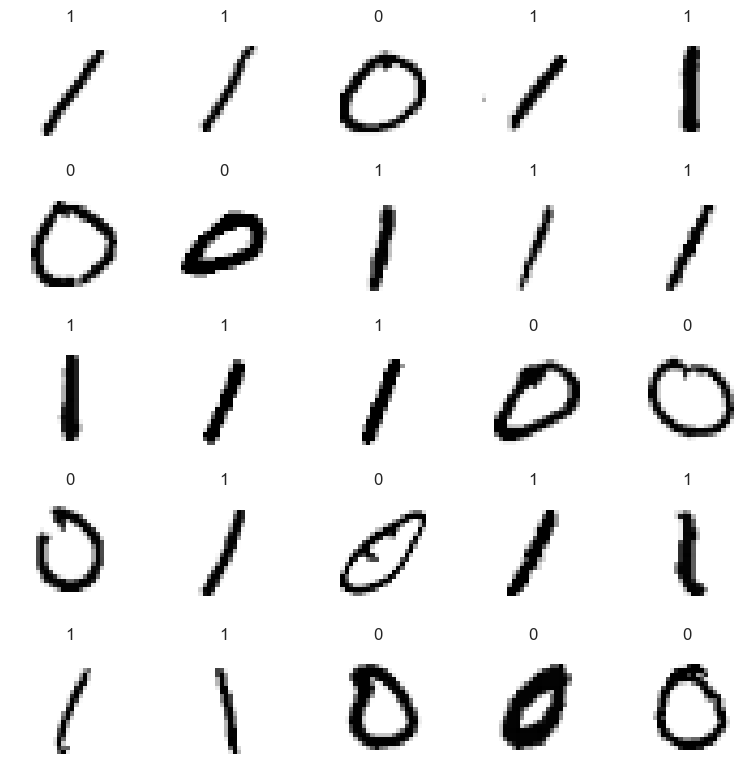

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = 1/2.54  # centimeters in inches

def plot_mnist_digits(x, y=None, start=0, randomise=False, seed=None, n=25):
    """
    Plot `n` images from `x` in a grid. By default plots 25 images in a 5x5 panel.

    Parameters
    ----------
    x : array-like, shape (N, 28, 28) or (N, n_features)
        Image array.
    y : array-like, optional
        Labels corresponding to images.
    start : int
        Index of first image to plot (ignored when randomize=True).
    randomise : bool
        If True select `n` random images.
    seed : int or None
        Random seed for reproducible selection.
    n : int
        Number of images to plot (default 16).
    """
    x = np.asarray(x)
    N = x.shape[0]

    # determine grid shape (try square-ish)
    nrows = int(np.floor(np.sqrt(n)))
    ncols = int(np.ceil(n / nrows))

    # select indices
    if randomise:
        rng = np.random.default_rng(seed)
        indices = rng.choice(N, size=n, replace=False)
    else:
        indices = np.arange(start, start + n) % N

    cm = 1/2.54  # centimeters in inches
    fig, axes = plt.subplots(nrows, ncols, figsize=(20*cm, 20*cm))
    axes = np.array(axes).flatten()

    for i, idx in enumerate(indices):
        ax = axes[i]
        if x.ndim == 3:
            img = x[idx]
        else:
            # assume flattened; try to reshape to 28x28 if possible
            try:
                img = x[idx].reshape(28, 28)
            except Exception:
                img = x[idx]
        ax.imshow(img, cmap=sns.color_palette("Grays", as_cmap=True))
        if y is not None:
            ax.set_title(f'{y[idx]}', fontsize=12)
        ax.axis('off')

    # turn off any unused subplots
    for j in range(len(indices), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_mnist_digits(x_01, y_01, randomise=True)

## 1 - Data Exploration and Visualization

Before building classifiers, we first need to **understand the data**. In this section, we will:
- Split the dataset into **training** and **test** sets
- Compute and interpret the **average image** for each class

The MNIST subset we will use contains **14,780 images** of handwritten digits *0* and *1*.
We will use the first **6/7** of the images for training and the remaining **1/7** for testing.


#### 🎯 Question 1a. Train/Test Split

Write a function that takes as input $f\in(0,1)$ and splits the data the arrays `x_01` and `y_01` into a **training set** (first fraction $ f $ of the samples and labels) and a **test set** (remaining fraction $ 1 - f$).

Store the results as:
- `x_01_train`, `y_01_train` -- training data and labels
- `x_01_test`, `y_01_test` -- test data and labels

In [5]:
def split_train_test(x, y, f=6/7):
    """
    Get train/test split suitable for binary and multi-class use.

    Parameters
    ----------
    x : array-like, shape (N, 28, 28) or (N, n_features)
        Images (either 3D raw images or already flattened 2D array).
    y : array-like, shape (N,)
        Labels.
    f : float
        Fraction of data to use for training (0 < f < 1).

    Returns
    -------
    X_train, y_train, X_test, y_test
        Flattened (if requested) images and corresponding labels.
    """
    X = np.asarray(x)
    y = np.asarray(y)

    # Validate labels
    assert y.ndim == 1, "`y` must be a 1D array of labels"
    n_samples = y.shape[0]

    # Accept either already-flattened (2D) or raw images (3D) without changing them
    if X.ndim not in (2, 3):
        raise AssertionError("`x` must be a 2D (N, features) or 3D (N, 28, 28) array")

    assert X.shape[0] == n_samples, "Number of samples in `x` and `y` must match"
    assert 0.0 < f < 1.0, "`f` must be in the interval (0, 1)"

    n_train = int(round(f * n_samples))

    return X[:n_train], y[:n_train], X[n_train:], y[n_train:]

x_01_train, y_01_train, x_01_test, y_01_test = split_train_test(x_01, y_01, f=6/7)

#### 🎯 Question 1b. Computing Templates and distance

A simple way to understand what distinguishes the two classes is to compute their **average images** (also called *templates*).

Compute the average image for each digit:
$$
\boldsymbol{m}_0 = \frac{1}{N_0} \sum_{n | y^{(n)} = 0} \boldsymbol{x}^{(n)}, \quad
\boldsymbol{m}_1 = \frac{1}{N_1} \sum_{n | y^{(n)} = 1} \boldsymbol{x}^{(n)}
$$

where $N_0$ and $N_1$ are the number of training examples for each class. Store these as `m0` and `m1` -- both should have shape (28, 28). Then compute their **difference** -- which is also a matrix (28, 28) -- $$\boldsymbol{d} = \boldsymbol{m}_1 - \boldsymbol{m}_0\ .$$ Plot `m0`, `m1`, `d` side by side using `plt.imshow()` -- use the palette `RdBu` or `bwr` for `d`.

Interpretation:
- Positive values indicate pixels where digit 1 tends to be brighter than digit 0
- Negative values indicate pixels where digit 0 tends to be brighter than digit 1
- This difference vector $\boldsymbol{d}$ captures the **direction** in pixel space that best separates the two classes

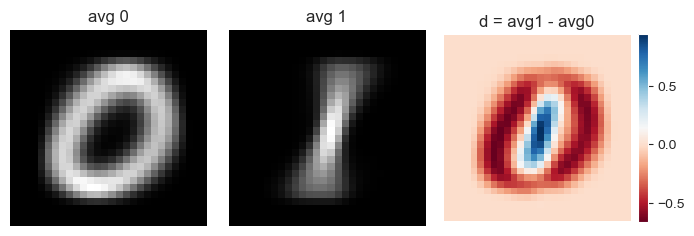

In [6]:
def compute_average_images(X, y, labels=None):
    """
    Compute average image for each class.

    Accepts X of shape (N, n_features) or (N, H, W). Returns per-class
    averages with shape (n_features,) for flattened input or (H, W)
    for image input.

    Parameters
    ----------
    X : array (n_samples, n_features) or (n_samples, H, W)
        Training images (flattened or raw).
    y : array (n_samples,)
        Training labels.
    labels : None, int, or iterable of ints, optional
        List of class labels to compute averages for. If None, uses all
        unique labels found in `y`.
    """
    X = np.asarray(X)
    y = np.asarray(y)

    if labels is None:
        labels = np.unique(y)
    else:
        if np.isscalar(labels):
            labels = (int(labels),)
        else:
            labels = tuple(int(l) for l in labels)

    averages = {}
    for label in labels:
        mask = (y == label)
        if np.sum(mask) == 0:
            raise ValueError(f"No samples found for label {label}")
        averages[label] = X[mask].mean(axis=0)

    return averages


def plot_avg_and_diff(img0, img1, d, labels=(0, 1)):
    """
    Plot the two class average images and their difference.

    NOTE: This function requires that the three inputs (avg_dict[labels[0]],
    avg_dict[labels[1]] and d) are already 2D arrays of shape (28, 28).
    """
    # color maps
    cmap_gray = sns.color_palette('gray', as_cmap=True)
    cmap_div = sns.color_palette('RdBu', as_cmap=True)

    # retrieve arrays
    img0 = np.asarray(img0)
    img1 = np.asarray(img1)
    diff = np.asarray(d)

    # validate inputs are 28x28 images
    for name, img in (('avg_dict[labels[0]]', img0), ('avg_dict[labels[1]]', img1), ('d', diff)):
        if img.ndim != 2 or img.shape != (28, 28):
            raise ValueError(f"{name} must be a 2D array with shape (28, 28)")

    fig, axes = plt.subplots(1, 3, figsize=(18 * cm, 6 * cm))
    axes = np.array(axes).flatten()

    # show average for label 0
    axes[0].imshow(img0, cmap=cmap_gray)
    axes[0].set_title(f'avg {labels[0]}', fontsize=12)
    axes[0].axis('off')

    # show average for label 1
    axes[1].imshow(img1, cmap=cmap_gray)
    axes[1].set_title(f'avg {labels[1]}', fontsize=12)
    axes[1].axis('off')

    # show difference image
    im = axes[2].imshow(diff, cmap=cmap_div)
    axes[2].set_title(f'd = avg{labels[1]} - avg{labels[0]}', fontsize=12)
    axes[2].axis('off')

    fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


av_x = compute_average_images(x_01_train, y_01_train, labels=[0, 1])
d = av_x[1] - av_x[0]

plot_avg_and_diff(av_x[0],av_x[1], d)



#### 🎯 Question 1c. Flatten Images

Then, create **flattened versions** of the image arrays, reshaping each 28×28 image into a 784-dimensional vector:
- `x_train_flat` -- shape `(n_train, 784)`
- `x_test_flat` -- shape `(n_test, 784)`
- `d` -- shape `(784,)`

💡 *Hint:* Use the`.reshape()` method in NumPy. Each 28×28 image becomes a 1D vector of length 784.

Finally, print the shapes of all arrays to verify that your split is correct.

In [7]:
def flatten_images(X, verbose=False):
    """
    Flatten image array.

    Parameters
    ----------
    X : array-like
        - shape (N, H, W): N images -> returns array of shape (N, H*W)
        - shape (H, W): single image (must be 28x28) -> returns array of shape (H*W,)
    verbose : bool
        If True, print shapes before and after flattening.

    Returns
    -------
    ndarray
        Flattened images. For a single image returns a 1-D array.

    Raises
    ------
    AssertionError
        If input is not a 3D image array or a 2D single 28x28 image.
    """
    X = np.asarray(X)
    before_shape = X.shape

    # 3D array: (N, H, W) -> (N, H*W)
    if X.ndim == 3:
        n_samples = X.shape[0]
        X_flat = X.reshape(n_samples, -1)
        if verbose:
            print(f"flatten_images: before {before_shape} -> after {X_flat.shape}")
        return X_flat

    # 2D array: only accept a single image of shape (28, 28)
    if X.ndim == 2:
        if X.shape == (28, 28):
            X_flat = X.reshape(-1)
            if verbose:
                print(f"flatten_images: before {before_shape} -> after {X_flat.shape}")
            return X_flat
        raise AssertionError("2D input must be a single image with shape (28, 28)")

    raise AssertionError("`X` must be a 2D (28,28) image or a 3D array of images")

x_01_train = flatten_images(x_01_train, verbose=True)
x_01_test = flatten_images(x_01_test, verbose=True)
d = flatten_images(d, verbose=True)

flatten_images: before (12669, 28, 28) -> after (12669, 784)
flatten_images: before (2111, 28, 28) -> after (2111, 784)
flatten_images: before (28, 28) -> after (784,)


## 2 - Linear Classifier with Threshold Optimization

We have seen that the difference vector $\boldsymbol{d} = \boldsymbol{m}_1 - \boldsymbol{m}_0$ provides a natural direction for separating the two classes. In this section, we formalize this into a **linear classifier** and optimize its decision threshold.

This linear classifier will make predictions based on a simple rule:
$$
\hat{y}^{(n)} = \begin{cases}
1 & \text{if } \boldsymbol{d} \cdot \boldsymbol{x}^{(n)} > \theta \\
0 & \text{otherwise}
\end{cases}
$$

where $\theta$ is a **threshold** (also called **bias**), and $\boldsymbol{x}^{(n)}$ is the $n$-th training example. The classifier separates the input space into two regions using a **decision boundary**: the hyperplane where $\boldsymbol{d} \cdot \boldsymbol{x} = \theta$.

Note that $\boldsymbol{d} \cdot \boldsymbol{x}^{(n)} = \boldsymbol{m}_1 \cdot \boldsymbol{x}^{(n)} - \boldsymbol{m}_0 \cdot \boldsymbol{x}^{(n)}$, therefore the classifier effectively measures how much closer an input $\boldsymbol{x}^{(n)}$ is to the average image of class 1 versus class 0. The threshold $\theta$ determines where we draw the line between the two classes.

The key question is: **what is the optimal threshold $\theta^*$?**

#### 🎯 Question 2a. Computing the scores
Compute the **scores** for all training examples:
$$
s^{(n)} = \boldsymbol{x}^{(n)} \cdot \boldsymbol{d}
$$
Then, use the known train labels to plot a histogram of the scores for the two classes (0 and 1) using different colors.

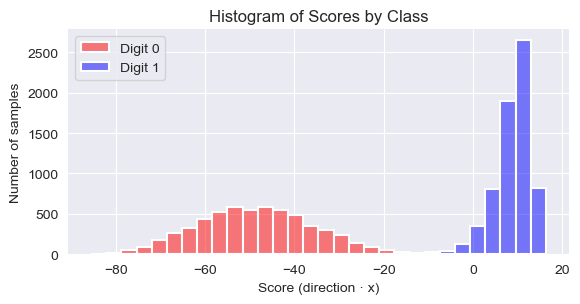

In [8]:
# compute scores along d and use training labels
scores = x_01_train @ d  # shape (n_train,)

def plot_scores_hist_by_class(scores, y, class_labels={0: 'Digit 0', 1: 'Digit 1'}, threshold=None):
    """
    Plot overlapping histograms of classifier scores for two classes.

    Parameters
    ----------
    scores : array-like, shape (n_samples,)
        Score values for all samples (e.g. X @ d).
    y : array-like, shape (n_samples,)
        True labels used to split the scores by class.
    class_labels : dict, optional
        Mapping from class value -> display label (e.g. {-1: 'neg', 1: 'pos'}).
        If None, the two unique classes in `y` are used and their string
        representations are used as display labels.
    threshold : float, optional
        Optional decision threshold to plot as a vertical line.
    """
    # histogram appearance settings
    bins = 30
    alpha = 0.5
    colors = ['red', 'blue']

    plt.figure(figsize=(15*cm, 8*cm))

    # Ensure arrays for boolean indexing
    scores = np.asarray(scores)
    y = np.asarray(y)

    # Determine class mapping
    if class_labels is None:
        unique = np.unique(y)
        if unique.size != 2:
            raise ValueError("`y` must contain exactly two classes when `class_labels` is None")
        class_labels = {unique[0]: str(unique[0]), unique[1]: str(unique[1])}
    elif not isinstance(class_labels, dict):
        raise TypeError("`class_labels` must be a dict mapping class_value -> display label")

    classes = list(class_labels.keys())
    if len(classes) != 2:
        raise ValueError("`class_labels` must contain exactly two entries")

    # Compute common bin edges so both histograms use identical bins
    bin_edges = np.linspace(np.nanmin(scores), np.nanmax(scores), bins + 1)

    sns.histplot(scores[y == classes[0]], bins=bin_edges, color=colors[0], alpha=alpha,
                 edgecolor='w', linewidth=1.5, label=f'{class_labels[classes[0]]}', stat='count', kde=False)

    sns.histplot(scores[y == classes[1]], bins=bin_edges, color=colors[1], alpha=alpha,
                 edgecolor='w', linewidth=1.5, label=f'{class_labels[classes[1]]}', stat='count', kde=False)

    # Optional threshold line
    if threshold is not None:
        plt.axvline(threshold, color='k', linestyle='--', linewidth=1.5,
                    label=rf'Threshold $\theta$={threshold:.2f}')

    sns.despine(left=True, bottom=True)
    # Labels, title and legend
    plt.xlabel('Score (direction · x)')
    plt.ylabel('Number of samples')
    plt.title('Histogram of Scores by Class')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_scores_hist_by_class(scores, y_01_train, class_labels={0: 'Digit 0', 1: 'Digit 1'})

#### 🎯 Question 2b. Linear Classifier and Classification Error

We now turn the score $ s = \boldsymbol{d} \cdot \boldsymbol{x} $ into an actual **decision rule** for classifying digits.

**2.b.i** / Write a function `linear_classifier_predict(x, d, theta)` that:
- Takes as input:
  - `x`: array of flattened images, shape (n_samples, 784)
  - `d`: direction vector, shape (784,)
  - `theta`: scalar threshold
- Returns:
  - `y_pred`: predicted labels (0 or 1), shape (n_samples,)

The prediction rule is: predict 1 if $\boldsymbol{d} \cdot \boldsymbol{x} > \theta$, else predict 0.

**2.b.ii** / To evaluate classifier performance, we need to measure how often it makes mistakes. Write a function `compute_error_rate(y_true, y_pred)` that takes true labels `y_true` and predicted labels `y_pred` and returns the **error rate** (fraction of mistakes):
$$
\text{Error} = \frac{1}{N} \sum_{n=1}^{N} 1 - \delta_{y_{\text{pred}}^{(n)}\ ,\ y_{\text{true}}^{(n)}}
$$
where $\delta_{a,b}$ is the Kroenecker function (1 if $a=b$, 0 otherwise).


**2.b.iii** / Using $\theta = 0$, compute and print the training error and test error.
Do these numbers tell you the classifier is working well?

In [9]:
def linear_classifier_predict(X, d, theta=0.0):
    """
    Predict labels using linear classifier with direction d and threshold theta

    Decision rule: predict 1 if d·x > theta, else predict 0

    Parameters
    ----------
    X : array (n_samples, n_features)
        Data to classify (flattened images)
    d : array (n_features,)
        Direction vector (e.g., difference of averages)
    theta : float
        Decision threshold

    Returns
    -------
    predictions : array (n_samples,)
        Predicted labels (0 or 1)
    """
    scores = X @ d  # Compute d·x for all samples
    predictions = (scores > theta).astype(int)
    return predictions


def compute_error_rate(y_true, y_pred, verbose=False):
    """
    Compute classification error rate

    Parameters
    ----------
    y_true : array (n_samples,)
        True labels
    y_pred : array (n_samples,)
        Predicted labels
    verbose : bool
        If True, print number of correct predictions and mistakes

    Returns
    -------
    error_rate : float
        Error rate (proportion of mistakes, between 0 and 1)
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if y_true.size == 0:
        if verbose:
            print("No samples provided.")
        return 0.0

    mistakes = np.sum(y_true != y_pred)
    correct = y_true.size - mistakes
    error_rate = mistakes / y_true.size

    if verbose:
        print(f"Correct: {correct}, Mistakes: {mistakes} | Error rate: {error_rate*100 :.2f}%")

    return error_rate

# Using theta = 0
theta = 0.0

print(f"Training set, theta = {theta}")
y_train_pred = linear_classifier_predict(x_01_train, d, theta)
train_error = compute_error_rate(y_01_train, y_train_pred, verbose=True)

print(f"Test set, theta = {theta}")
y_test_pred = linear_classifier_predict(x_01_test, d, theta)
test_error = compute_error_rate(y_01_test, y_test_pred, verbose=True)

Training set, theta = 0.0
Correct: 12391, Mistakes: 278 | Error rate: 2.19%
Test set, theta = 0.0
Correct: 2075, Mistakes: 36 | Error rate: 1.71%


#### 🎯 Question 2c. Finding the Optimal Threshold

The threshold $\theta$ is a hyperparameter we can optimize. We will search for the threshold that minimizes the training error.

**Algorithm**: Grid search for optimal threshold

1. Create an array `theta_values` of 200 evenly-spaced thresholds between the minimum and maximum projection scores on the training set
2. For each threshold in `theta_values`, compute the training error and store in an array `errors`
3. Find the optimal threshold: `theta_star = theta_values[np.argmin(errors)]`

In [10]:
def find_best_threshold(X, y, d, theta_values, verbose=False):
    """
    Find the best threshold by trying multiple values

    Parameters
    ----------
    X : array (n_samples, n_features)
        Training data
    y : array (n_samples,)
        True labels
    d : array (n_features,)
        Direction vector
    theta_values : array (n_thresholds,)
        Array of threshold values to try
    verbose : bool
        If True, print the selected best theta and its training error

    Returns
    -------
    results : dict
        Dictionary containing:
        - best_theta: optimal threshold
        - best_error: error rate at optimal threshold
        - errors: array of error rates for all thresholds
        - theta_values: input array of thresholds
    """
    errors = np.zeros(len(theta_values))

    # Try each threshold
    for i, theta in enumerate(theta_values):
        y_pred = linear_classifier_predict(X, d, theta)
        errors[i] = compute_error_rate(y, y_pred)

    # Find best threshold (minimum error)
    best_idx = np.argmin(errors)
    best_theta = theta_values[best_idx]
    best_error = errors[best_idx]

    if verbose:
        print(f"Best theta: {best_theta:.6g}, training error: {best_error*100:.2f}%")

    return {
        'best_theta': best_theta,
        'best_error': best_error,
        'errors': errors,
        'theta_values': theta_values,
    }

X = x_01_train
y = y_01_train
scores_all = X @ d

theta_values = np.linspace(scores.min(), scores.max(), 200)

results = find_best_threshold(X, y, d, theta_values, verbose=True)

Best theta: -11.2923, training error: 0.41%


#### 🎯 Question 2d. **Visualization and Reporting**.

Plot the training error as a function of $\theta$ with clear axis labels. Mark $\theta^*$ on the plot with a vertical dashed line.

Plot the histograms in (2.a) again, this time adding a vertical line at $\theta^*$ to visualize the decision boundary.

Compute and report the training and test error at $\theta^*$.

**Interpretation**: What shape does the error curve have? Why? How do the training and test errors at $\theta^*$ compare?

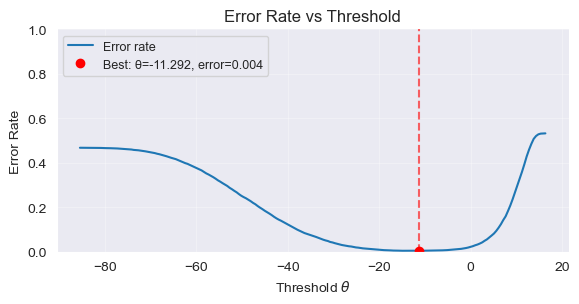

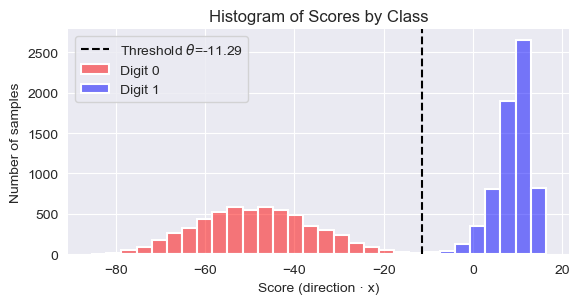

Training set, theta = -11.29
Correct: 12617, Mistakes: 52 | Error rate: 0.41%
Test set, theta = -11.29
Correct: 2104, Mistakes: 7 | Error rate: 0.33%


In [11]:
def plot_error_vs_theta(theta_values, errors, best_theta=None):
    """
    Plot error rate as a function of threshold.

    Returns (fig, ax) so you can further manipulate or display the figure.
    """

    theta_values = np.asarray(theta_values)
    errors = np.asarray(errors)

    if theta_values.size == 0 or errors.size == 0:
        raise ValueError("`theta_values` and `errors` must be non-empty arrays")

    fig, ax = plt.subplots(figsize=(15*cm, 8*cm))

    # Plot error curve
    ax.plot(theta_values, errors, '-', color='C0', linewidth=1.5, label='Error rate')

    # Mark best threshold if provided
    if best_theta is not None:
        # find nearest index safely
        idx = np.argmin(np.abs(theta_values - best_theta))
        best_error = errors[idx]
        ax.plot(best_theta, best_error, 'ro', markersize=6,
                label=f'Best: θ={best_theta:.3f}, error={best_error:.3f}')
        ax.axvline(best_theta, color='r', linestyle='--', alpha=0.6)

    ax.set_xlabel(r'Threshold $\theta$', fontsize=10)
    ax.set_ylabel('Error Rate', fontsize=10)
    ax.set_title('Error Rate vs Threshold', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    ax.set_ylim(0.0, 1.0)  # error rates are in [0,1]
    sns.despine(fig=fig)
    fig.tight_layout()
    plt.show()

    return

plot_error_vs_theta(theta_values, results['errors'], best_theta=results['best_theta'])

plot_scores_hist_by_class(scores, y_01_train, threshold=results['best_theta'])

# Using theta = 0
theta = results['best_theta']

print(f"Training set, theta = {theta:.2f}")
y_train_pred = linear_classifier_predict(x_01_train, d, theta)
train_error = compute_error_rate(y_01_train, y_train_pred, verbose=True)

print(f"Test set, theta = {theta:.2f}")
y_test_pred = linear_classifier_predict(x_01_test, d, theta)
test_error = compute_error_rate(y_01_test, y_test_pred, verbose=True)